In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# standard library imports
import os
import requests
from pathlib import Path
import tarfile
#import copy => to make a deep copy when save checkpoint
import json
# import typing ...  Note: any production code uses typing, so good to get used to it.


# third party imports
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# use torchinfo


In [2]:
# Check torch version and CUDA status if GPU is enabled.
print(f"PyTorch Version: {torch.__version__}")

gpu_avail = torch.cuda.is_available()
print(f"GPU available: {gpu_avail}")

PyTorch Version: 2.1.0+cu121
GPU available: True


In [3]:
# Create device agnostic code - Use GPU if it's available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Clear cache if using GPU
if str(device) == 'cuda':
    torch.cuda.empty_cache()

Device: cuda


In [4]:
# Every machine learning framework, e.g. PyTorch, provides functions that are stochastic, like generating random numbers.
# Set code to be reproducible with the exact same random numbers by setting a seed.

def manual_seed(random_seed=42):
    """
    Function for maintaining reproducibility
    Args:
        random_seed: Integer [Default: 42]
    Returns:
        None
    """
    # for non-cuda device
    torch.manual_seed(random_seed)

    # The seed between CPU and GPU is not synchronized; set the seed on the GPU separately to ensure reproducible code.
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)

    # Some operations on a GPU are implemented stochastic for efficiency; ensure all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

manual_seed()

In [5]:
# Get flower dataset
# defining directory path for flower dataset
data_dir = './flowers'

# using pathlib.Path for handling PosixPath
FLOWERS_DIR = Path(data_dir)

# downloading and setting up data if not already present
if not FLOWERS_DIR.is_dir():
    # creating directory
    FLOWERS_DIR.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Directory created: ./{FLOWERS_DIR}")

    print() # for readability

    # tarball path
    TARBALL = FLOWERS_DIR / "flower_data.tar.gz"

    # downloading and writing the tarball to './flowers' directory
    print(f"[INFO] Downloading the file 'flower_data.tar.gz' to ./{FLOWERS_DIR}")
    request = requests.get('https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz')
    # writing downloaded content to the tarball
    with open(TARBALL, "wb") as file_ref:
        file_ref.write(request.content)
        print(f"[INFO] 'flower_data.tar.gz' saved to ./{FLOWERS_DIR}")

    print() # for readability

    # extracting the downloaded tarball to dataset directory
    print(f"[INFO] Extracting the downloaded tarball to ./{FLOWERS_DIR}")
    with tarfile.open(TARBALL, "r") as tar_ref:
        tar_ref.extractall(FLOWERS_DIR)
        print(f"[INFO] 'flower_data.tar.gz' extracted successfully to ./{FLOWERS_DIR}")

    print() # for readability

    # using os.remove to delete the downloaded tarball
    print("[INFO] Deleting the tarball to save space.")
    os.remove(TARBALL)
else:
    print(f"[INFO] Dataset already setup at ./{FLOWERS_DIR}")

[INFO] Directory created: ./flowers

[INFO] Downloading the file 'flower_data.tar.gz' to ./flowers
[INFO] 'flower_data.tar.gz' saved to ./flowers

[INFO] Extracting the downloaded tarball to ./flowers
[INFO] 'flower_data.tar.gz' extracted successfully to ./flowers

[INFO] Deleting the tarball to save space.


In [6]:
# creating JSON file for flower categories, mapping integer encoded categories to the flower names. String integers (class) mapped to flower names
data = {
    "21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster",
    "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy",
    "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly",
    "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist",
    "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower",
    "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation",
    "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone",
    "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow",
    "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid",
    "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia",
    "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura",
    "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium",
    "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily",
    "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william",
    "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon",
    "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula",
    "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower",
    "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple",
    "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus",
    "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily",
    "46": "wallflower", "77": "passion flower", "51": "petunia"
}

with open('cat_to_name.json', 'w') as file:
    json.dump(data, file)

In [7]:
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# New Section

In [8]:
# Define the transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


In [9]:
# Load the datasets with ImageFolder, applying transforms

# 1. training dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)

# 2. validation dataset
validation_dataset = datasets.ImageFolder(valid_dir, transform=test_transforms)

# 3. test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# extracting number of classes and class_to_idx mapping
CLASSES = train_dataset.classes
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = train_dataset.class_to_idx

In [10]:
# extracting number of classes and class_to_idx mapping
#CLASSES = train_dataset.classes
#NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = train_dataset.class_to_idx

In [11]:
# selecting hyperparameters -- what the model will NOT learn through training, these we set when determining how to train model.
# These will be passed in as options from command line in part 2

BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 5
HIDDEN_LAYER_1 = 256
#HIDDEN_LAYER_2 = 128

In [12]:
# defining the dataloaders

# 1. training set dataloader
trainloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=os.cpu_count() if str(device) == "cuda" else 0,
                                          pin_memory=True if str(device) == "cuda" else False)

# 2. validation set dataloader
validationloader = torch.utils.data.DataLoader(validation_dataset,
                                               batch_size = BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=os.cpu_count() if str(device) == "cuda" else 0,
                                               pin_memory=True if str(device) == "cuda" else False)

# 3. test set dataloader
testloader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size = BATCH_SIZE,
                                         shuffle=False,
                                         num_workers=os.cpu_count() if str(device) == "cuda" else 0,
                                         pin_memory=True if str(device) == "cuda" else False)

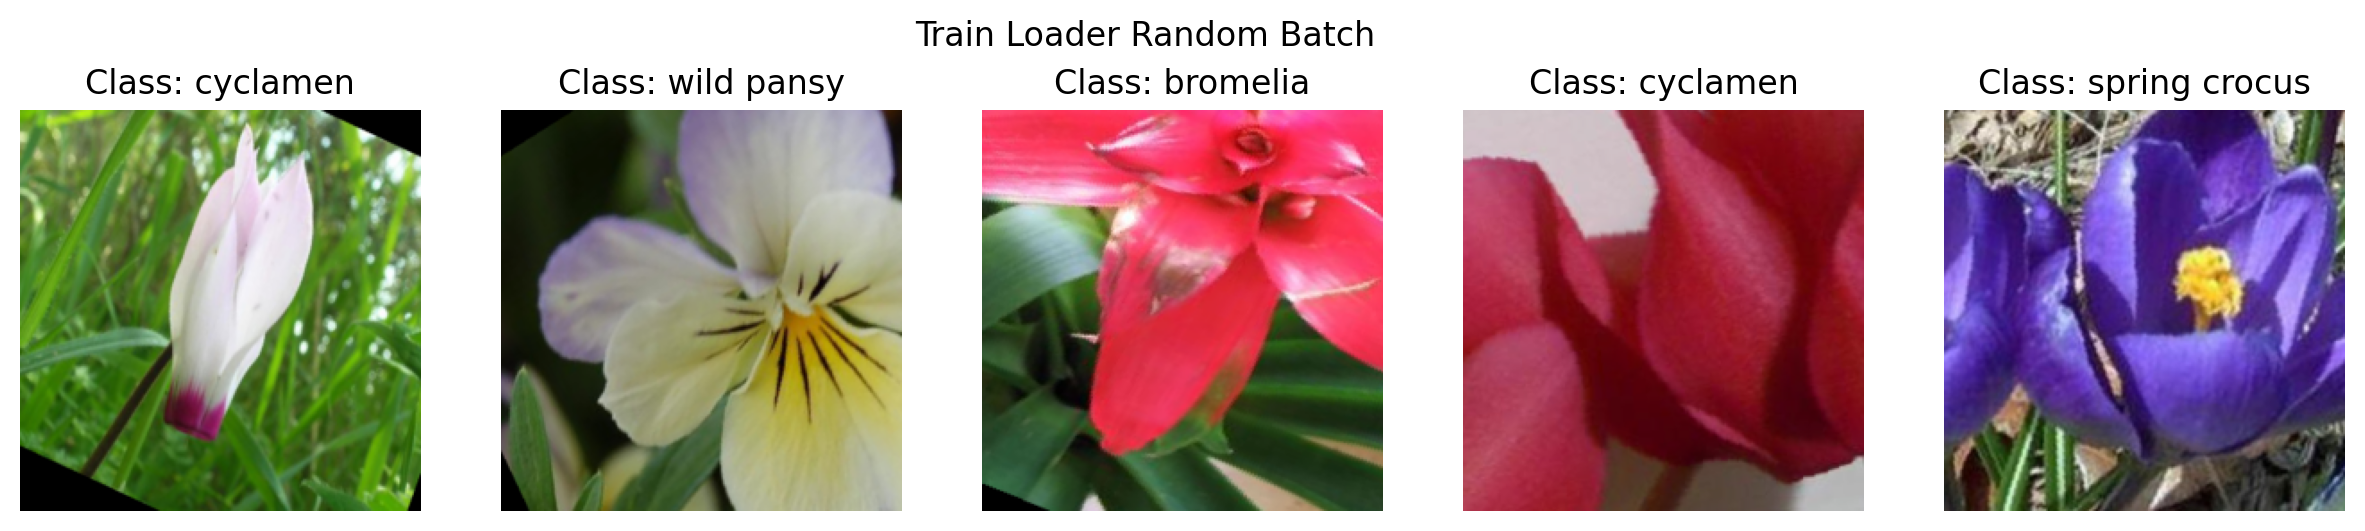

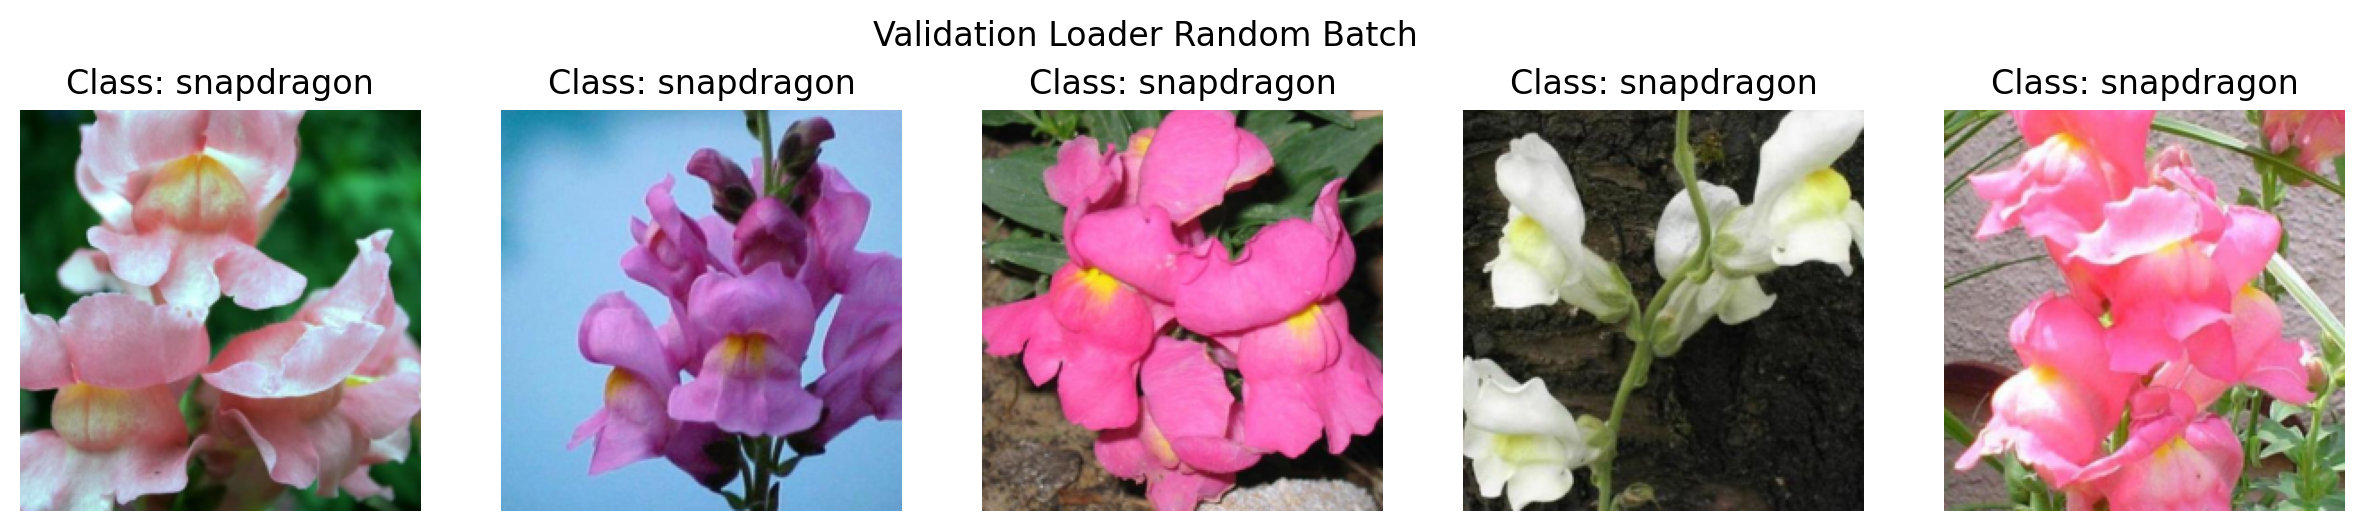

In [13]:
# Let's look at some of our data!

# Mean and Std used to normalise data for this model
#mean = np.array([0.485, 0.456, 0.406])
#std = np.array([0.229, 0.224, 0.225])

def denormalize_and_clip(image, mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])):
    """
    Denormalizes and clips an image to display.
    Args:
        image: one image to denormalise and clip
        mean: Model specific NumPy array, used with dataloaders to normalize data
              [Default: np.array([0.485, 0.456, 0.406])]
        std: Model specific NumPy array, used with dataloaders to normalize data
              [Default: np.array([0.229, 0.224, 0.225])
    Returns:
        One denormalized and clipped image.
    """
    # Ensure NumPy array
    image = image.numpy() if isinstance(image, torch.Tensor) else image
    image = np.transpose(image, (1, 2, 0))

    # Denormalize and clip values to stay in the valid range [0, 1]
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

def imshow(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Remove ticks and axes
    plt.show()

def visualize_random_batch(data_loader, loader_type,
                           mean=np.array([0.485, 0.456, 0.406]),
                           std=np.array([0.229, 0.224, 0.225]),
                           mapping_file='cat_to_name.json'):
    """
    Gets a random batch of image data from a dataset, denormalizes the images,
    and displays them with their class names.
    Args:
        image: the image to denormalise and clip
        data_loader: The dataloader for a dataset
        loader_type: String. Description of the type of dataloader used for data_loader
        mean: Model specific NumPy array, used with dataloaders [Default: np.array([0.485, 0.456, 0.406])]
        std: Model specific NumPy array, used with dataloaders [Default: np.array([0.229, 0.224, 0.225])
    Output:
        Displays the images in a grid with their class names.
    Returns:
        None
    """
    # Get a random batch index
    batch_index = np.random.randint(len(data_loader))

    # Get the random batch from the data loader
    for i, (images, labels) in enumerate(data_loader):
        if i == batch_index:
            break

    # Display images from the random batch in a grid
    num_images_to_show = min(5, len(images))  # Display at most 5 images
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))

    with open(mapping_file, 'r') as f:
        classnum_to_classname = json.load(f)

    idx_to_class = {v: k for k, v in CLASS_TO_IDX.items()}

    for i in range(num_images_to_show):
        image = images[i]
        label = labels[i].item()

        class_num = idx_to_class[label]
        class_name = classnum_to_classname[class_num]

        # Show the image
        image = denormalize_and_clip(image, mean, std)  # Apply denormalization
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {class_name}')
        axes[i].axis('off')  # Remove ticks and axes

    plt.suptitle(f'{loader_type} Random Batch')
    plt.show()


visualize_random_batch(trainloader, 'Train Loader')  # Visualization of a random batch from the training set
visualize_random_batch(validationloader, 'Validation Loader')  # Visualization of a random batch from the validation set

In [14]:
# Choose model -- ResNet-34
# Note in older versions of PyTorch have to write <models.resnet34(pretrained=true)>,
# so if I ever run Part 2 in Udacity workspace have to change this to pretrained=True

# using ResNet-34 DEFAULT weights - best available weights for pretrained model
resnet_34_weights = models.ResNet34_Weights.DEFAULT

# creating ResNet-34 architecture using the weights specified above
model = models.resnet34(weights = resnet_34_weights)

#model

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 81.6MB/s]


In [15]:
# Swapping out ResNet classifier head

# Turns off gradients for the model - freeze the complete network
for param in model.parameters():
    param.requires_grad = False

# Defines new classifier
classifier = nn.Sequential(nn.Linear(512, HIDDEN_LAYER_1),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(HIDDEN_LAYER_1, len(train_dataset.classes)))

# Swaps out classifier head
model.fc = classifier

In [16]:
# Creating criterion and optimizer

criterion = nn.CrossEntropyLoss()

# Only trains the classifier parameters, feature parameters remain frozen
optimizer = optim.Adam(model.fc.parameters(), lr = LEARNING_RATE)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
def run_evaluation(model, data_loader, criterion, device=device):
    """
    Evaluates model for accuracy and loss
    Args:
        model: The model/network to evaluate
        data_loader: The dataloader for evaluation dataset
        criterion: The error function for setting up the optimization problem
        device: The device being used for model/network training + eval [Default: device]

    Returns:
        Tuple of evaluation accuracy, evaluation loss
    """
    # Ensure model on default device
    model.to(device)
    # Set model to evaluation mode
    model.eval()

    total_eval_loss = 0
    total_eval_accuracy = 0


    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device).type(torch.long) # I have not imported type!  If change to other optimizer don't need to do this.
        with torch.no_grad():
          logits = model(images)
          batch_loss = criterion(logits, labels)
          total_eval_loss += batch_loss.item()

          ps = torch.exp(logps)
          top_ps, top_class = ps.topk(1, dim=1)
          equality = top_class == labels.view(*top_class.shape)
          total_eval_accuracy += torch.mean(equality.type(torch.FloatTensor)).item()

        eval_loss = total_eval_loss/len(data_loader)
        eval_accuracy = total_eval_accuracy /len(data_loader)

    return (eval_accuracy, eval_loss)


In [18]:
def train_model(model, trainloader, validationloader, criterion, optimizer, epochs=EPOCHS, device=device):
    """
    Defines the model training pipeline,
    with evaluation of training loss, validation loss, and validation accuracy
    at regular intervals during training; these are printed out as well as
    stored in their respective lists and returned as part of a training statistics dictionary.

    Args:
        model: The model/network to train
        trainloader: The dataloader for training dataset
        validationloader: The dataloader for validation dataset
        criterion: The error function for setting up the optimization problem
        optimizer: The optimization algorithm to use
        epochs: The number of epochs to train the model for [Default: EPOCHS]
        device: The device being used for model/network training + eval [Default: device]

    Output:
        Prints the training loss, validation loss, and validation accuracy, as
        calculated at regular intervals during training.

    Returns:
        A dictionary of training statistics containing training losses (list),
        evaluation losses (list), and validation accuracy (list).
    """

    # Ensure model on default device
    model.to(device)
    # Set model to train mode
    model.train()

    running_loss = 0
    print_every = 100

    accuracy, train_losses, eval_losses = [], [], []

    # Training loop
    for epoch in range(epochs):
        for step, (images, labels) in enumerate(trainloader, 1):
            images, labels = images.to(device), labels.to(device).type(torch.long)      # typecasting labels as using CE Loss

            logits = model(images)
            loss = criterion(logits, labels)
            running_loss += loss.item()

            # Before calculating the gradients, we need to ensure that they are all zero.
            # Otherwise, the gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()
            # Update the parameters
            optimizer.step()

            # Drop out of the training loop and test the network's accuracy and loss on validation dataset
            if step % print_every == 0:
                train_losses.append(running_loss/print_every)

                eval_accuracy, eval_loss = run_evaluation(model, validationloader)

                eval_losses.append(eval_loss)
                accuracy.append(eval_accuracy)

                print(f"Epoch {epoch+1}    "
                      f"Train loss: {running_loss/step:.3f}    "
                      f"Validation loss: {eval_loss:.3f}    "
                      f"Validation accuracy: {eval_accuracy*100:.2f}%" )

                running_loss = 0
                # Set model back to train mode
                model.train()

    training_statistics = {"validation_accuracy": accuracy,
                           "validation_losses": eval_losses,
                           "train_losses": train_losses}

    return training_statistics

In [19]:
training_statistics = train_model(model, trainloader, validationloader, criterion, optimizer, EPOCHS)

Epoch 1    Train loss: 4.026    Validation loss: 3.018    Validation accuracy: 32.29%
Epoch 1    Train loss: 1.355    Validation loss: 1.684    Validation accuracy: 59.96%
Epoch 2    Train loss: 1.965    Validation loss: 1.101    Validation accuracy: 72.44%
Epoch 2    Train loss: 0.730    Validation loss: 0.862    Validation accuracy: 79.11%
Epoch 3    Train loss: 1.389    Validation loss: 0.739    Validation accuracy: 81.04%
Epoch 3    Train loss: 0.569    Validation loss: 0.614    Validation accuracy: 85.42%
Epoch 4    Train loss: 1.082    Validation loss: 0.570    Validation accuracy: 85.36%
Epoch 4    Train loss: 0.523    Validation loss: 0.517    Validation accuracy: 87.17%
Epoch 5    Train loss: 0.952    Validation loss: 0.491    Validation accuracy: 88.01%
Epoch 5    Train loss: 0.463    Validation loss: 0.459    Validation accuracy: 87.89%


In [20]:
#Note: the test dataset has already been process for use by model, if using a different (third party) data set this won't be the case.
# Would then need to process the dataset for use by model.

def test_model_accuracy(model, data_loader=testloader):
    """
    Evaluates model for accuracy and loss using testdataset.
    Prints the test accuracy.
    Args:
        model: The model/network to evaluate
        data_loader: The dataloader for test dataset [Default: testloader]
    Output:
        Prints the test accuracy as a percentage.
    Returns:
        Tuple of test accuracy, test loss
    """
    test_accuracy, test_loss = eval_model(model, data_loader)

    print(f"Test Accuracy: {test_accuracy*100:.2f}%")

    return test_accuracy, test_loss

In [21]:
test_model_accuracy(model)

Test Accuracy: 86.49%


(0.86487854214815, 0.5146535815527806)

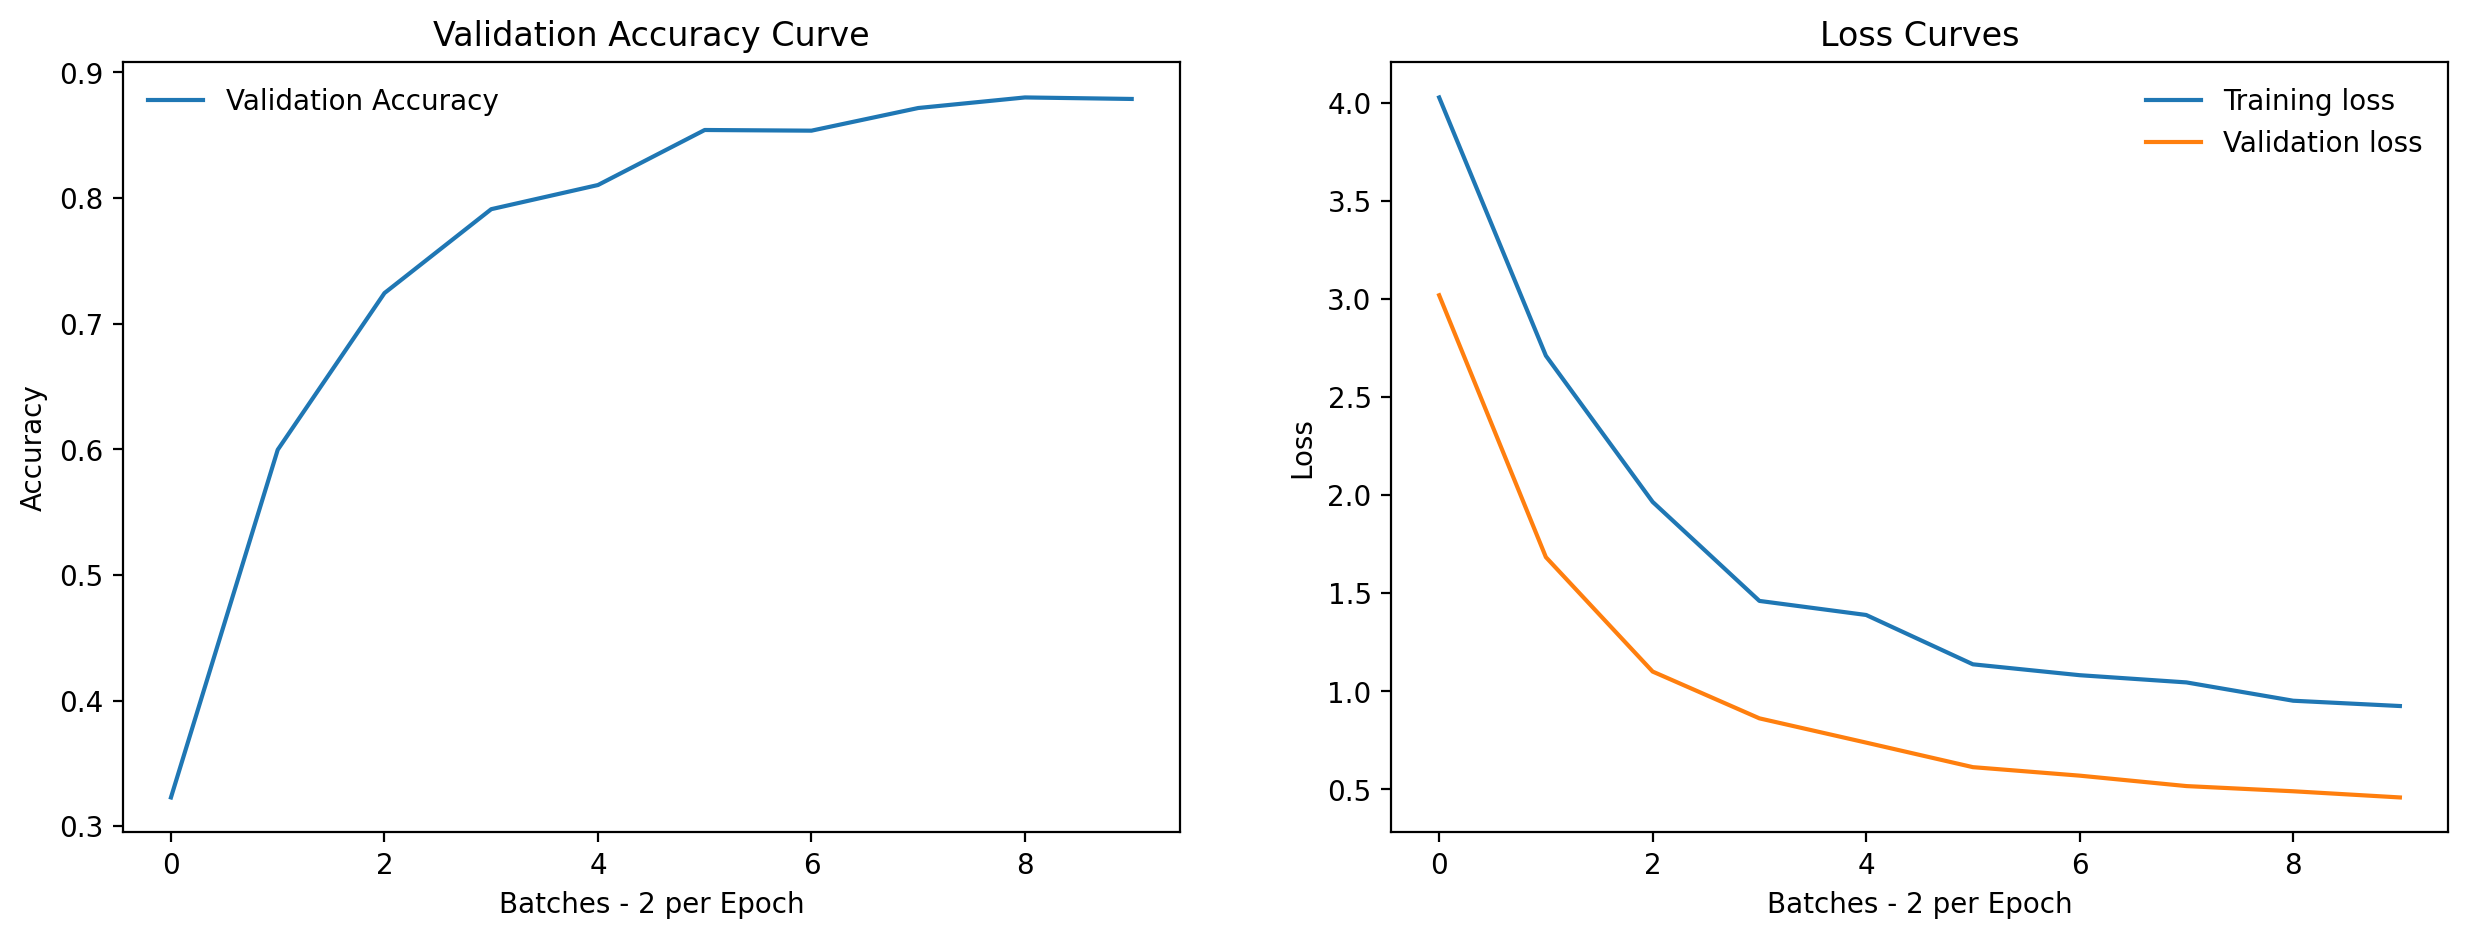

In [22]:
# Plot Training loss and Validation loss

def plot_training_stats_curves(stats):
    """
    Plots data from model training statistics directory.
    Args:
        stats: dictionary of model training stats
    Output:
        Two graphs. One is the Validation Accuracy Curve from training stats.
        The other graph contains two loss curves graphing Training loss and Validation loss
    Returns:
        None
    """
    # Extract data from the dictionary
    train_losses = stats['train_losses']
    eval_losses = stats['validation_losses']
    validation_accuracy = stats['validation_accuracy']

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.title('Validation Accuracy Curve')
    plt.xlabel('Batches - 2 per Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False)

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training loss')
    plt.plot(eval_losses, label='Validation loss')
    plt.title('Loss Curves')
    plt.xlabel('Batches - 2 per Epoch')
    plt.ylabel('Loss')
    plt.legend(frameon=False)


plot_training_stats_curves(training_statistics)

#Hmm, wouldn't mind changing ticks to 1, 2,3, 4 (to reflect epochs, then could change x-axis title)
# xticks([0, 1, 2], ['January', 'February', 'March'],
#rotation=20)  # Set text labels and properties.
# be nice to set ticks to divide by two?

In [48]:
#CLASS_TO_IDX = train_dataset.class_to_idx
# Also want to save the optimizer state: 'optimizer': optimizer.state_dict

def save_checkpoint(filepath='checkpoint.pth', train_dataset=train_dataset):
    """
    Saves the a checkpoint for a model to a given file path.
    """
    checkpoint = {'input_size': 512,
                'output_size': len(train_dataset.classes),
                'hidden_layer1': 256,
                'dropout1': 0.2,
                'state_dict': model.state_dict(),
                'class_to_idx': train_dataset.class_to_idx}

    torch.save(checkpoint, filepath)

save_checkpoint('checkpoint.pth')
# download checkpoint file
#files.download('checkpoint.pth')

In [26]:
def load_model(filepath='checkpoint.pth'):
    checkpoint = torch.load(filepath)
    model = models.resnet34(weights = False)

    # Defines a new classifier
    classifier = nn.Sequential(nn.Linear(checkpoint['input_size'], checkpoint['hidden_layer1']),
                               nn.ReLU(),
                               nn.Dropout(checkpoint['dropout1']),
                               nn.Linear(checkpoint['hidden_layer1'], checkpoint['output_size']))
    model.fc = classifier

    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    return model

In [27]:
model = load_model('checkpoint.pth')
print(model)
print(model.class_to_idx)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
# Inference for classification
# First we need a function to handle processing an input image such that it can be used for inference in the network.

def process_image(image_path):
    """
    Scales, crops, and normalizes a PIL image for a PyTorch model.

    Args:
        image_path: Path to an image to process

    Returns:
        A Tensor representing the processed image.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")

    img_transform = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

    image_tensor = img_transform(image)

    return image_tensor

<Axes: >

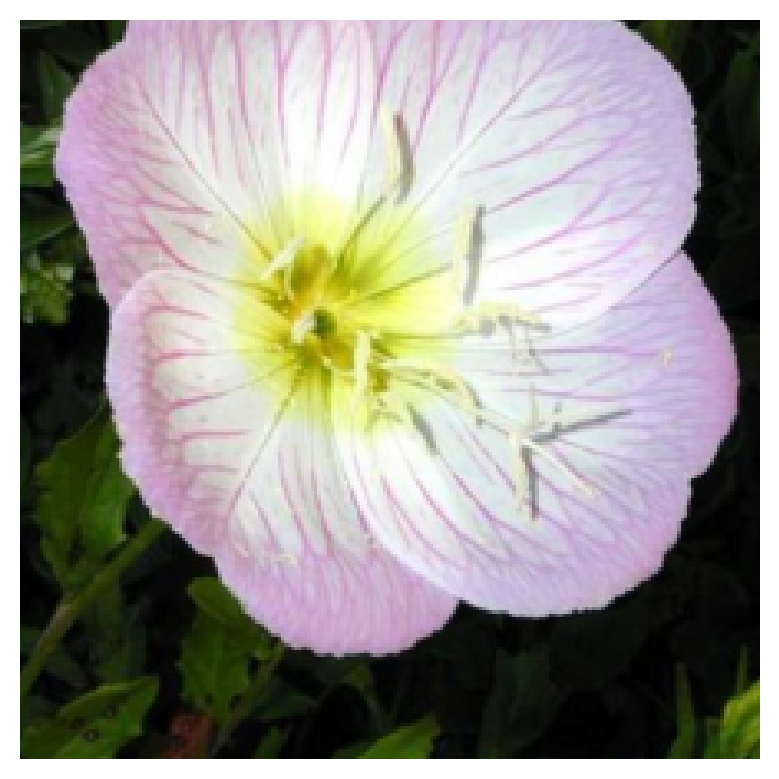

In [29]:
# Function to check if process_image function works correctly.
# Running the output of process_image through this function should return the original image (except for cropped out portions)

def imshow_for_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.axis('off')  # Remove ticks and axes
    ax.imshow(image)

    return ax


flower_img_path = (test_dir + '/1/image_06743.jpg')
imshow_for_tensor(process_image(flower_img_path))

In [30]:
def predict(image_path, model, topk=5, device=device):
    """
    Predict the class (or classes) of an image using a trained deep learning model.
    Args:
        image_path: a path to an image to be used for model inference
        model: a model checkpoint
        topk: Integer denoting number of top probabilites to select [Default: 5]
        device: [Default: device]
    Returns:
        A tuple containing the probabilities (NumPy array) and classes (NumPy array)
    """
    # Load and preprocess the image
    processed_image_tensor = process_image(image_path)
    # Ensure processed image on device
    input_tensor = processed_image_tensor.unsqueeze(0).to(device)

    model = load_model(model)

    # Move model to device and switch to eval mode
    model.to(device)
    model.eval()

    # Make predictions
    with torch.no_grad():
        output = model(input_tensor)

    # Convert the output to probabilities using softmax
    probabilities = F.softmax(output[0], dim=0)

    probs, indices = probabilities.topk(topk)
    # Convert probs, indices tensors to NumPy arrays
    probs = probs.numpy(force=True)
    indices = indices.numpy(force=True)

    # invert class_to_idx
    class_to_idx = model.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    # Get classes (represented by nums, which can be used to map to class flower names)
    classes = [idx_to_class[index] for index in indices]

    return probs, classes

In [31]:
flower_img_path = (test_dir + '/1/image_06743.jpg')
probs, classes = predict(flower_img_path, 'checkpoint.pth')
print(probs)
print(classes)

[9.2764825e-01 6.3272096e-02 5.1284884e-03 1.1880795e-03 5.9112953e-04]
['1', '86', '76', '83', '51']


<PIL.Image.Image image mode=RGB size=500x601 at 0x7BABE8324460>


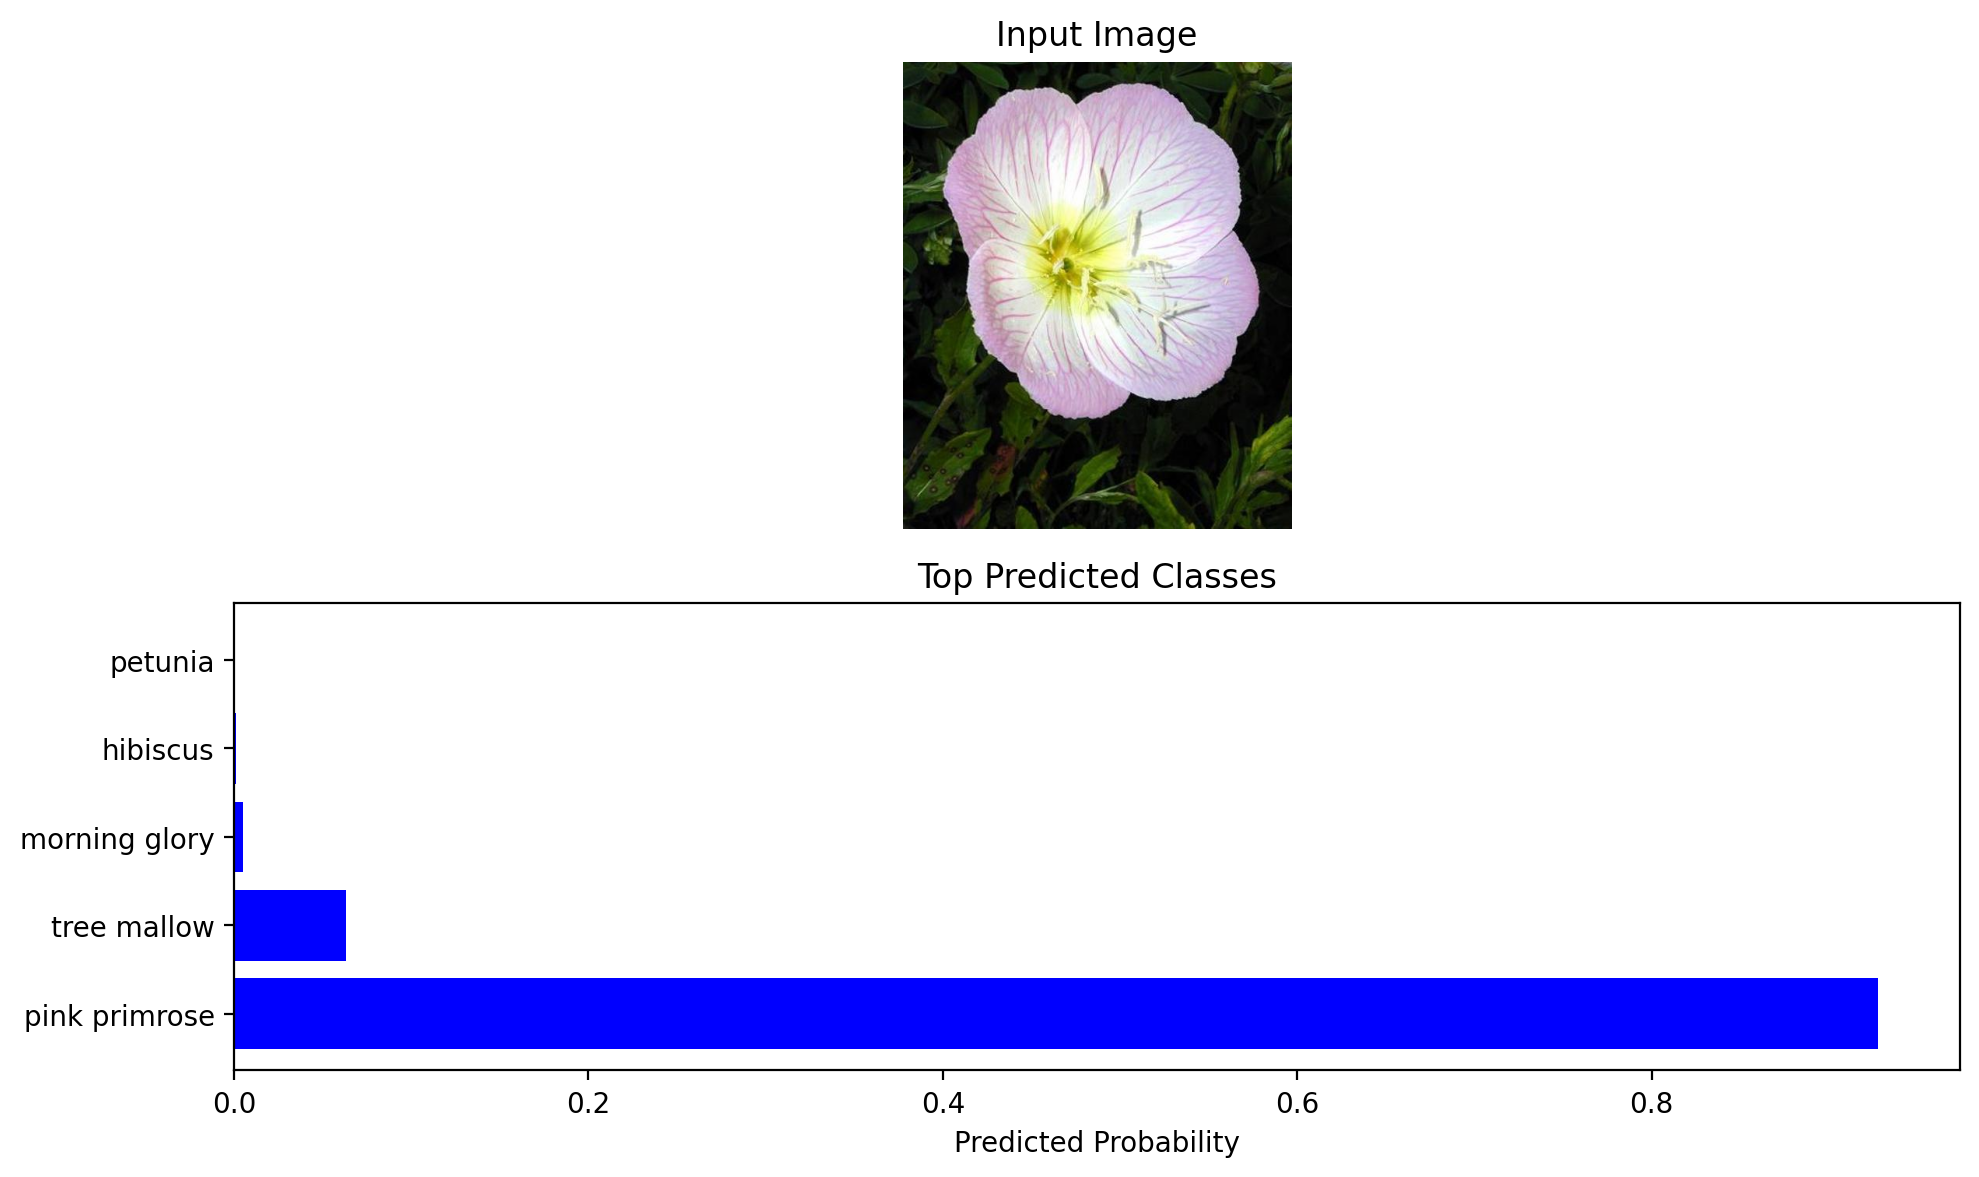

In [47]:
def sanity_check(image_path, model='checkpoint.pth', mapping_file='cat_to_name.json'):
    """

    """
    image = Image.open(image_path).convert("RGB")

    with open(mapping_file, 'r') as f:
        classnum_to_classname = json.load(f)

    #get class num (which is the directory num that image is located in within flowers datasets)
    end_i = image_path.rfind('/')
    start_i = image_path[:end_i].rfind('/')
    class_num = image_path[start_i+1:end_i]

    image_title = f"Input Image: {classnum_to_classname[str(class_num)]}"

    # Get top-k predictions
    probs, classes = predict(image_path, model)

    class_names = [classnum_to_classname[class_num] for class_num in classes]

    # Create a horizontal bar graph
    plt.figure(figsize=(10, 6))

    # Plot the image
    plt.subplot(2, 1, 1)
    plt.imshow(image)
    plt.title(image_title)
    plt.axis('off')

    # Plot the top-k classes
    plt.subplot(2, 1, 2)
    plt.barh(class_names, probs, color='blue')
    plt.xlabel("Predicted Probability")
    plt.title("Top Predicted Classes")

    plt.tight_layout()
    plt.show()


flower_img_path = (test_dir + '/1/image_06743.jpg')
sanity_check(flower_img_path)